In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tqdm import tqdm
from scipy.interpolate import PchipInterpolator


from n3fit.model_gen import pdfNN_layer_generator
from n3fit.io.writer import XGRID

from validphys.api import API

Using Keras backend


In [2]:
np.random.seed(0)

In [3]:
# Number of networks to initialize with random parameters
number_of_networks = 100

# input xgrid for which to produce the corresponding outputs
input_xgrid = XGRID.reshape(1,-1,1)
xgrid_plot = input_xgrid.flatten()


In [4]:
# read basis settings from a fit runcard (optional, but basis_info is useful)
fit_info = API.fit(fit="NNPDF40_nnlo_as_01180_1000").as_input()

basis_info = fit_info["fitting"]["basis"]

nodes = fit_info["parameters"]["nodes_per_layer"]
activations = fit_info["parameters"]["activation_per_layer"]
initializer_name = fit_info["parameters"]["initializer"]
layer_type = fit_info["parameters"]["layer_type"]
dropout = fit_info["parameters"]["dropout"]

In [5]:
# remove preprocessing
for binf in basis_info:
    binf['smallx'] = [1, 1]
    binf['largex'] = [0, 0]

In [6]:
input_arr=np.loadtxt("featurescaling_grid.dat").reshape(-1,1)
interpolation_points = 5

# input_arr = np.concatenate(input_list, axis=1)
input_arr = np.sort(input_arr)
input_arr_size = input_arr.size

# Define an evenly spaced grid in the domain [0,1]
# force_set_smallest is used to make sure the smallest point included in the scaling is 1e-9, to
# prevent trouble when saving it to the LHAPDF grid
force_set_smallest = input_arr.min() > 1e-9
include_endpoint = 1.0 in input_arr # if 1.0 is in the xgrid it should also be 1.0 in the output xgrid
if force_set_smallest:
    new_xgrid = np.linspace(
        start=1 / input_arr_size, stop=1.0, endpoint=include_endpoint, num=input_arr_size
    )
else:
    new_xgrid = np.linspace(start=0, stop=1.0, endpoint=include_endpoint, num=input_arr_size)

# When mapping the FK xgrids onto our new grid, we need to consider degeneracies among the x-values
# in the FK grids
unique, counts = np.unique(input_arr, return_counts=True)
map_to = []
for cumsum_ in np.cumsum(counts):
    # Make sure to include the smallest new_xgrid value, such that we have a point at
    # x<=1e-9
    map_to.append(new_xgrid[cumsum_ - counts[0]])
map_to = np.array(map_to)
map_from = unique

#  If needed, set feature_scaling(x=1e-9)=0
if force_set_smallest:
    map_from = np.insert(map_from, 0, 1e-9)
    map_to = np.insert(map_to, 0, 0.0)

# Select the indices of the points that will be used by the interpolator
onein = map_from.size / (int(interpolation_points-1))
selected_points = [round(i * onein - 1) for i in range(1, int(interpolation_points))]
if selected_points[0] != 0:
    selected_points = [0] + selected_points
selected_points += [1] # add also this one since 1e-9 is just an outlier

# make a mask of which pints to keep
mask = np.zeros(len(map_from), dtype=bool)
mask[selected_points] = True

# apply the mask and lot the input
masked_map_from = map_from[mask]
log_masked_map_from = np.log(masked_map_from)
masked_map_to = map_to[mask]

# construct the scaler
try:
    featurescaler = PchipInterpolator(log_masked_map_from, masked_map_to)
except ValueError as e:
    raise ValueError(
        "interpolation_points is larger than the number of unique input x-values"
    ) from e

In [7]:
def scaler(x):
    x_scaled = featurescaler(np.log(x))
    x_scaled = 2 * x_scaled - 1
    return np.concatenate([x_scaled, x], axis=-1)

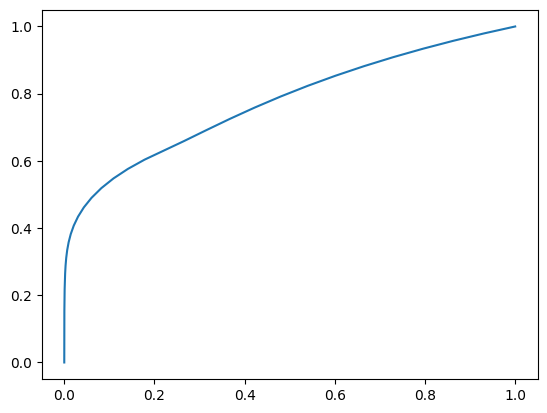

In [17]:
plt.plot(input_arr, featurescaler(np.log(input_arr)))

(array([1657.,  218.,  119.,  119.,  123.,  123.,    0.,  123.,  123.,
           0.,  123.,    0.,    0.,  123.,    0.,  123.,    0.,    0.,
         123.,    0.,    0.,  123.,    0.,  123.,    0.,    0.,  123.,
           0.,    0.,    0.,  123.,    0.,    0.,  123.,    0.,    0.,
         123.,    0.,    0.,  123.,    0.,    0.,    0.,  123.,    0.,
           0.,  123.,    0.,    0.,  125.]),
 array([1.00000000e-09, 2.00000010e-02, 4.00000010e-02, 6.00000009e-02,
        8.00000009e-02, 1.00000001e-01, 1.20000001e-01, 1.40000001e-01,
        1.60000001e-01, 1.80000001e-01, 2.00000001e-01, 2.20000001e-01,
        2.40000001e-01, 2.60000001e-01, 2.80000001e-01, 3.00000001e-01,
        3.20000001e-01, 3.40000001e-01, 3.60000001e-01, 3.80000001e-01,
        4.00000001e-01, 4.20000001e-01, 4.40000001e-01, 4.60000001e-01,
        4.80000001e-01, 5.00000001e-01, 5.20000000e-01, 5.40000000e-01,
        5.60000000e-01, 5.80000000e-01, 6.00000000e-01, 6.20000000e-01,
        6.40000000e-01, 

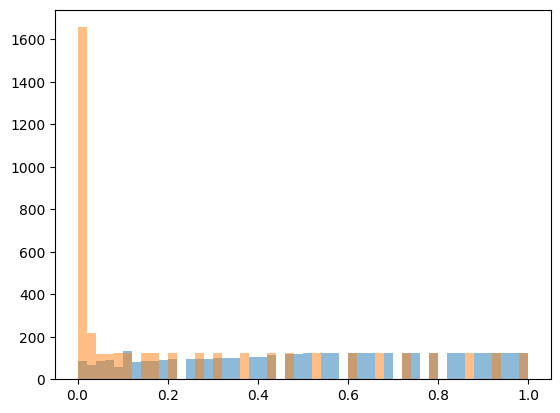

In [9]:
plt.hist(featurescaler(np.log(input_arr)), alpha=0.5, bins=50)
plt.hist(input_arr,alpha=0.5, bins=50)


In [10]:
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        nodes=[25, 20, 8],
        activations=["tanh", "tanh", "linear"],
        initializer_name="glorot_normal",
        layer_type="dense",
        flav_info=basis_info,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule=False,
        scaler=scaler,
    )


    # Generate predictions in 14-flavor basis
    out = pdf_model.predict({"pdf_input": input_xgrid.T}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
nn_outputs = np.array(nn_outputs)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/roy/miniconda3/envs/nnpdf/lib/python3.12/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'pdf_input' mapping to value <KerasTensor shape=(1, None, 2), dtype=float32, sparse=False, name=scaledx_x> which has name 'scaledx_x'. Change the tensor name to 'pdf_input' (via `Input(..., name='pdf_input')`)
  warnings.warn(
/Users/roy/miniconda3/envs/nnpdf/lib/python3.12/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'layer_x_eq_1' mapping to value <KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=x_eq_1> which has name 'x_eq_1'. Change the tensor name to 'layer_x_eq_1' (via `Input(..., name='layer_x_eq_1')`)
  warnings.warn(
/Users/roy/miniconda3/envs/nnpdf/lib/pytho

# Plots

In [11]:
# plot settings
pdf_names = ["\Sigma", "g", "V", "V3", "V8", "T3", "T8", "T15"]
color = "C0"

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/bp/5__28ghs21j7m1yhtq7941m00000gs/T/ipykernel_63209/977203723.py:2: SyntaxWarning: invalid escape sequence '\S'
  pdf_names = ["\Sigma", "g", "V", "V3", "V8", "T3", "T8", "T15"]


<Figure size 640x480 with 0 Axes>

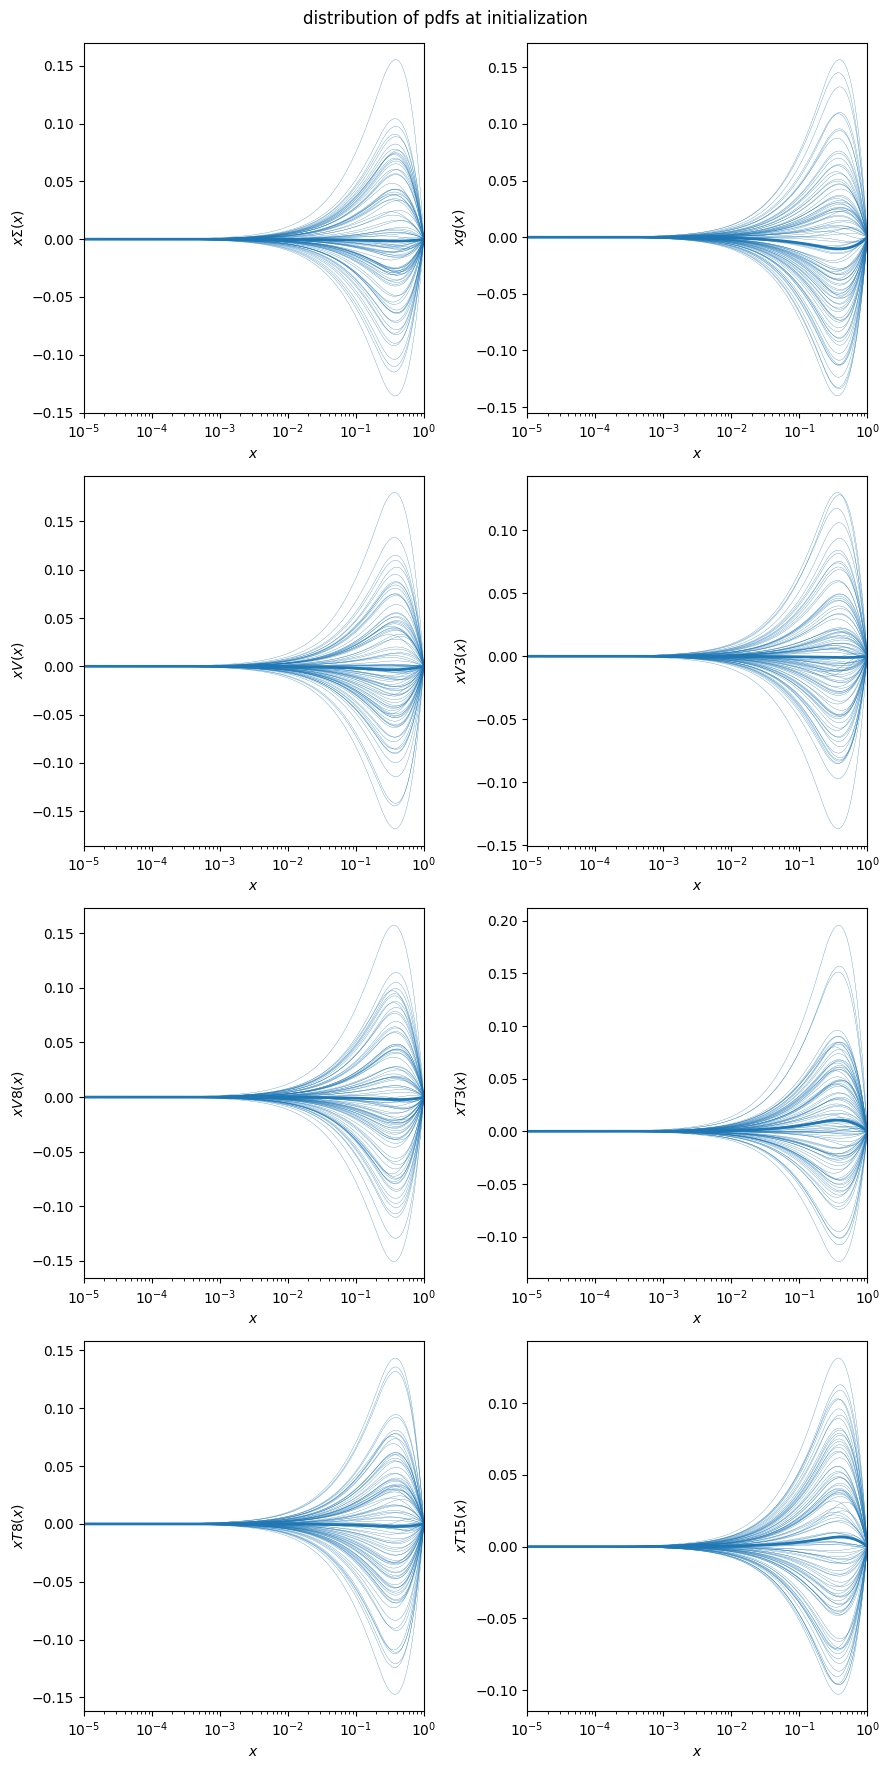

In [12]:
plt.clf()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    ax.plot(xgrid_plot, input_xgrid[:,:,0].T*nn_outputs[:,i,:].T, color=color, lw=0.2)
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    ax.plot(xgrid_plot, xgrid_plot*pdf_cv, color=color, lw=2)
    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig.suptitle("distribution of pdfs at initialization\n")
fig.tight_layout()

<Figure size 640x480 with 0 Axes>

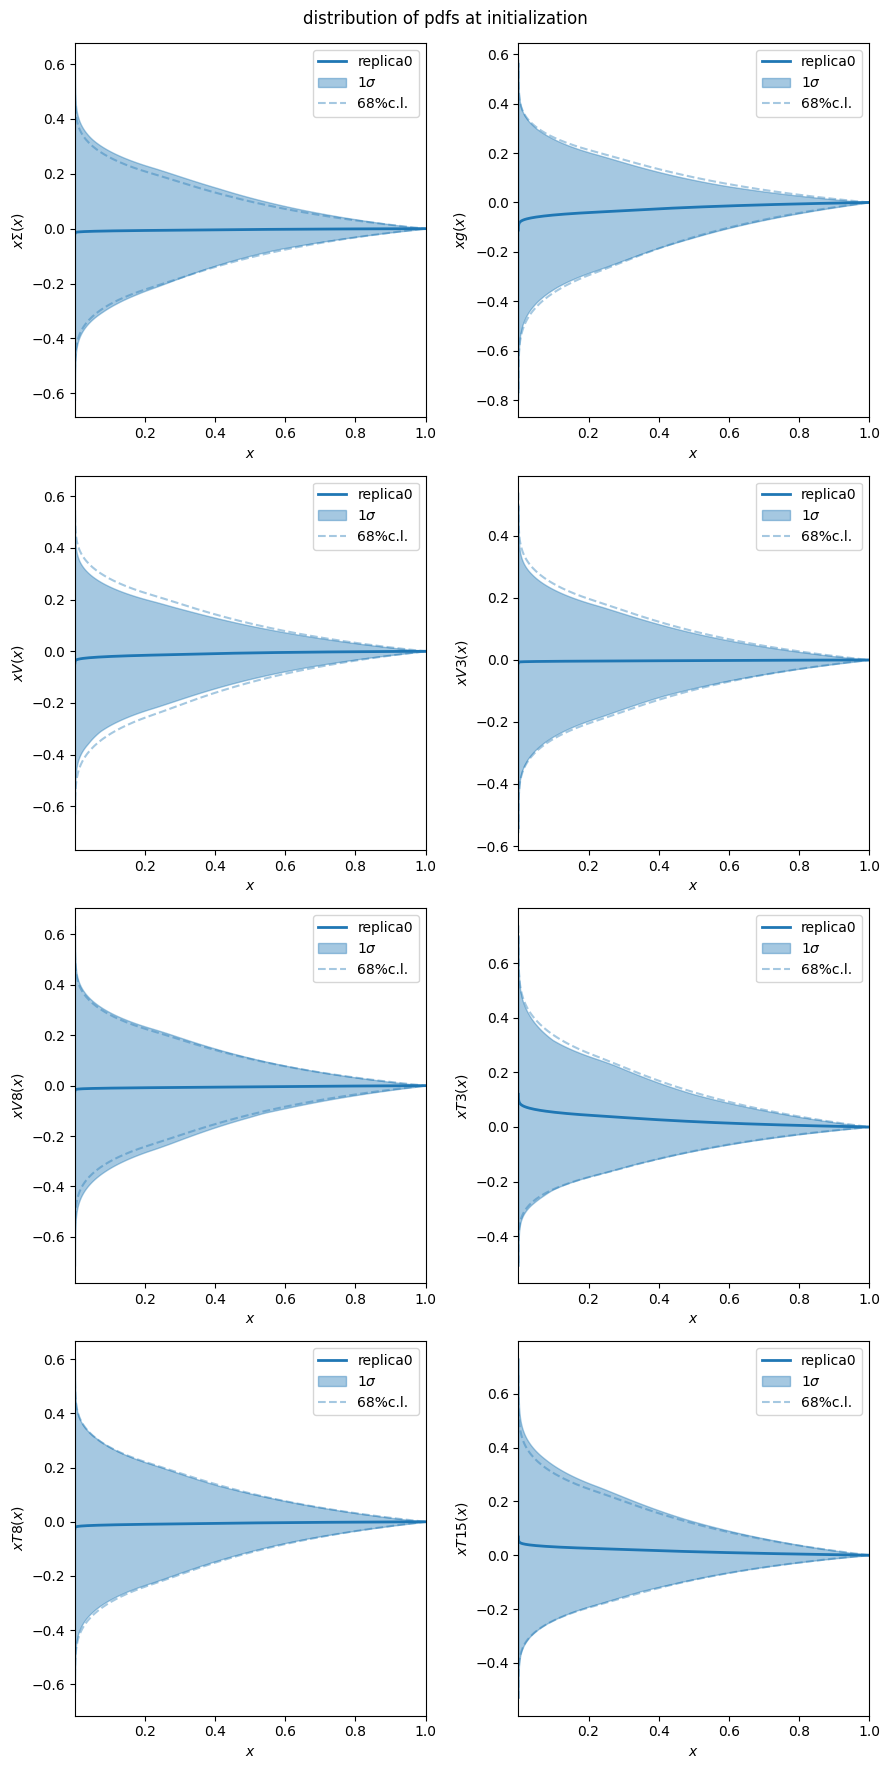

In [20]:
plt.clf()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(xgrid_plot, pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(xgrid_plot, cl_low, cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(xgrid_plot, (pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(xgrid_plot, (pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("linear")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig.suptitle("distribution of pdfs at initialization\n")
fig.tight_layout()

# Moments

In [14]:
# E[f_i](x)
pdfs_cv = nn_outputs.mean(axis=0).T

# Cov[f_i,f_j](x)
pdfs_cov = np.array([np.cov(nn_outputs[:,:,i].T) for i in range(XGRID.size)])

In [15]:
(((nn_outputs[:1000].mean(axis=0) - nn_outputs[:1000])**5).mean(axis=0)).max()

np.float32(0.009775095)

In [16]:
aa=np.random.randn(1000,200*8)*1
((aa.mean(axis=0) - aa)**3).mean(axis=0).max()

np.float64(0.2967270586080106)